In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from arch import arch_model

### Data:

C:\Users\negul\AppData\Local\Temp\ipykernel_32584\2111729386.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Data'] = data['Data'].str.replace('.', '-')


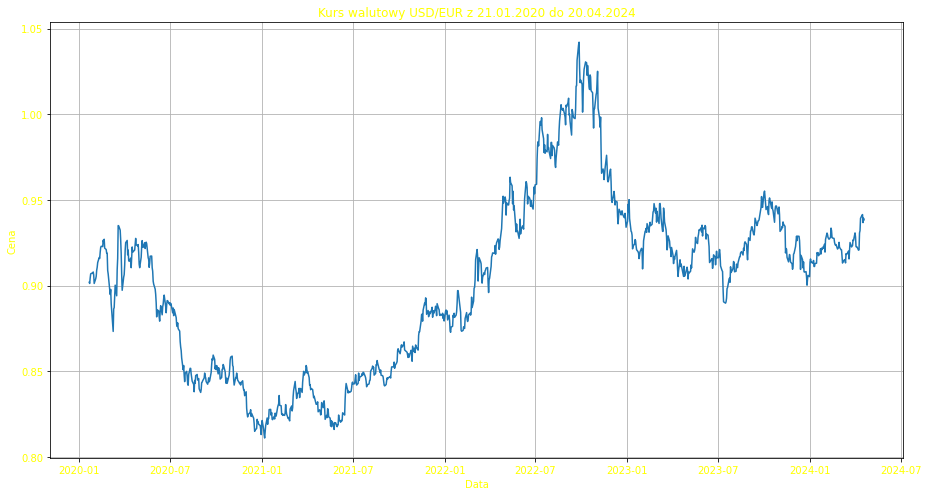

In [270]:
data = pd.read_csv("USD_EUR.csv")
data['Ostatnio'] = data['Ostatnio'].str.replace(',', '.').astype(float)
data['Data'] = data['Data'].str.replace('.', '-')
data['Data'] = pd.to_datetime(data['Data'], format='%d-%m-%Y')
data
plt.figure(figsize=[13,7])
plt.title('Kurs walutowy USD/EUR z 21.01.2020 do 20.04.2024', color = 'yellow')
plt.plot(data['Data'], data['Ostatnio'])
plt.xlabel('Data', color = 'yellow')
plt.ylabel('Cena', color = 'yellow')
plt.xticks(color = 'yellow')
plt.yticks(color = 'yellow')
plt.grid(True)
plt.tight_layout()
plt.savefig('Kurs_walutowy_USD_EUR.png')


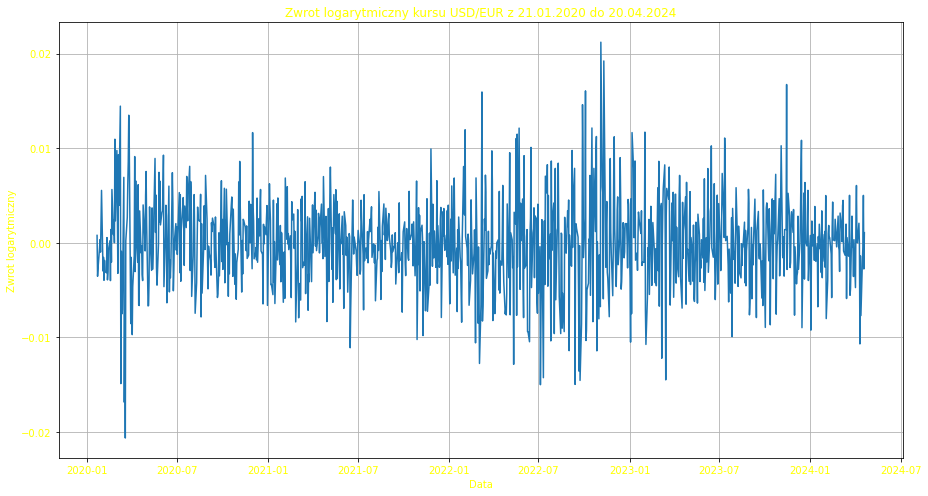

In [271]:
data["d_after"] = data["Ostatnio"].shift(-1)
data = data.fillna(data["Ostatnio"].iloc[-1])
data['log_return'] = np.log(data['d_after']/data['Ostatnio'])
data = data.drop(data.index[-1])
data['log_return'].tail()

plt.figure(figsize=[13,7])
plt.title('Zwrot logarytmiczny kursu USD/EUR z 21.01.2020 do 20.04.2024', color = 'yellow')
plt.plot(data['Data'], data['log_return'])
plt.xlabel('Data', color = 'yellow' )
plt.ylabel('Zwrot logarytmiczny', color = 'yellow')
plt.xticks(color = 'yellow')
plt.yticks(color = 'yellow')
plt.grid(True)
plt.tight_layout()
plt.savefig('Zwrot_USD_EUR.png')


## 1. Calculation of VaR95% and VaR99%
### a. parametric method with T-student distribution

In [272]:
params_t = stats.t.fit(data['log_return'])  
VaR_95_param = stats.t.ppf(0.05, df=params_t[0], loc=params_t[1], scale=params_t[2])
VaR_99_param = stats.t.ppf(0.01, df=params_t[0], loc=params_t[1], scale=params_t[2])
print ('Parametric method VaR95%:', VaR_95_param)
print ('Parametric method VaR99%:', VaR_99_param)

Var95 = np.zeros(len(data))
Var99 = np.zeros(len(data))
for j in range (0,len(data)):
    Var95[j] = VaR_95_param
    Var99[j] = VaR_99_param

data['VaR95%'] = Var95
data['VaR99%'] = Var99

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR95%']
data['violation99'] = data['log_return'] < data['VaR99%']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")

Parametric method VaR95%: -0.007754211978568066
Parametric method VaR99%: -0.012273711287348926
Liczba naruszeń VaR95%: 55
Liczba naruszeń VaR99%: 11


C:\Users\negul\AppData\Local\Temp\ipykernel_32584\1663493885.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(index=data['log_return'].index)


Liczba naruszeń VaR95%: 35
Liczba naruszeń VaR99%: 4


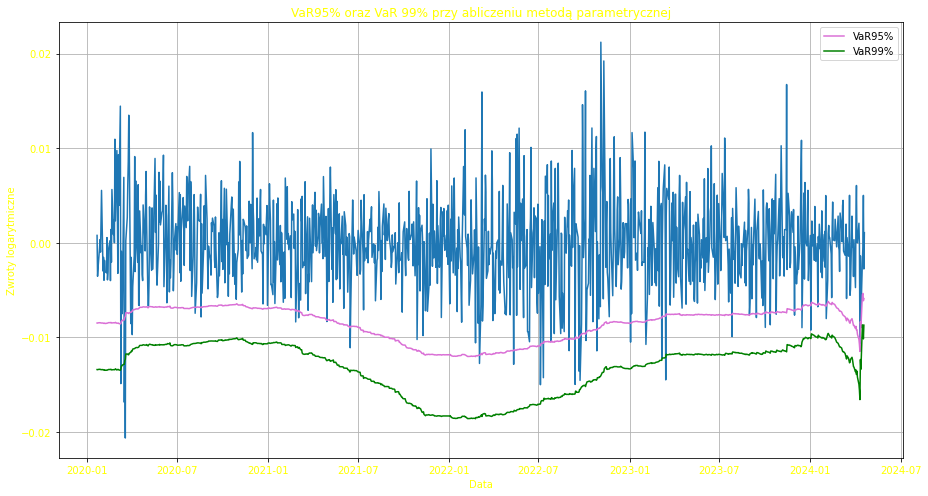

In [273]:

# Załóżmy, że 'log_return' to Twoja seria zwrotów w DataFrame
window = 260
alphas = [0.05, 0.01]
degrees_of_freedom =  8#params_t[0]  # Liczba stopni swobody dla rozkładu t-Studenta

# Dynamicznie dostosowane okno
Var_values = []
for alpha in alphas:
    values = pd.Series(index=data['log_return'].index)
    for i in range(len(data['log_return'])):
        current_window = min(window, i + 1)  # Nie przekracza liczby dostępnych dni
        # Obliczenie średniej i odchylenia standardowego dla aktualnego okna
        windowed_data = data['log_return'][:i+1].tail(current_window)
        mean = windowed_data.mean()
        std_dev = windowed_data.std()
        # Obliczenie VaR za pomocą funkcji odwrotnej dystrybuanty rozkładu t-Studenta
        values[i] = stats.t.ppf(alpha, df=degrees_of_freedom, loc=mean, scale=std_dev)
    Var_values.append(values)

data['VaR95%'] = Var_values[0]  # Ujemny znak, jeśli VaR ma reprezentować potencjalną stratę
data['VaR99%'] = Var_values[1]  # Ujemny znak, jeśli VaR ma reprezentować potencjalną stratę

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR95%']
data['violation99'] = data['log_return'] < data['VaR99%']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")

plt.figure(figsize=[13,7])
plt.title('VaR95% oraz VaR 99% przy abliczeniu metodą parametrycznej', color = 'yellow')
plt.plot(data['Data'], data['log_return'])
plt.plot(data['Data'], data['VaR95%'], label = 'VaR95%', color = 'orchid')
plt.plot(data['Data'], data['VaR99%'], label = 'VaR99%', color = 'green')
plt.xlabel('Data', color = 'yellow')
plt.ylabel('Zwroty logarytmiczne', color = 'yellow')
plt.xticks(color = 'yellow')
plt.yticks(color = 'yellow')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('param.png')



### b. historical method
#### i. usual method

In [274]:
print("Historical usual method VaR95%:", np.quantile(data['log_return'], 0.05))
print("Historical usual method VaR99%:", np.quantile(data['log_return'], 0.01))

Var95 = np.zeros(len(data))
Var99 = np.zeros(len(data))
for j in range (0,len(data)):
    Var95[j] = np.quantile(data['log_return'], 0.05)
    Var99[j] = np.quantile(data['log_return'], 0.01)

data['VaR95%'] = Var95
data['VaR99%'] = Var99

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR95%']
data['violation99'] = data['log_return'] < data['VaR99%']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")

Historical usual method VaR95%: -0.007687015884204237
Historical usual method VaR99%: -0.012152889911008867
Liczba naruszeń VaR95%: 56
Liczba naruszeń VaR99%: 12


C:\Users\negul\AppData\Local\Temp\ipykernel_32584\2063719435.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(index=data['log_return'].index)
C:\Users\negul\AppData\Local\Temp\ipykernel_32584\2063719435.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(index=data['log_return'].index)


Liczba naruszeń VaR95%: 60
Liczba naruszeń VaR99%: 18


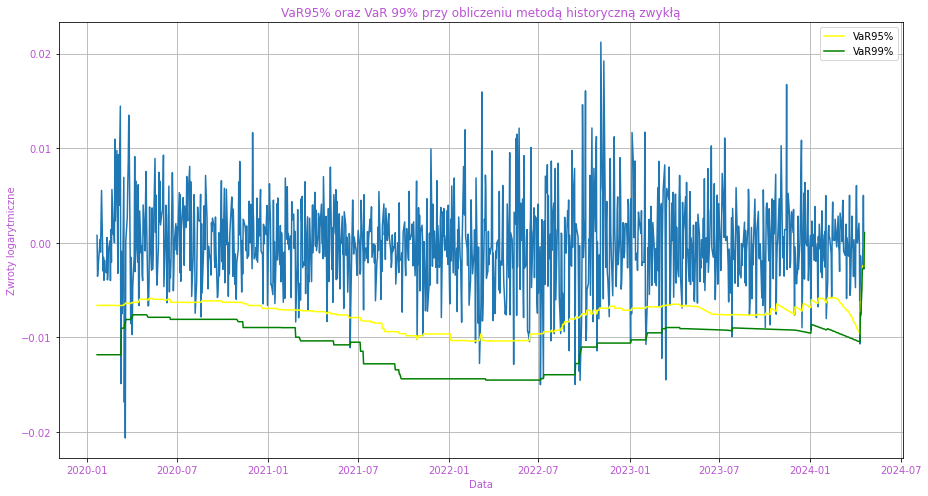

In [275]:
# Załóżmy, że 'returns' to Twoja seria zwrotów w DataFrame
window = 260
alphas = [0.05, 0.01]

# Dynamicznie dostosowane okno
Var_values = []
for alpha in alphas:
    values = pd.Series(index=data['log_return'].index)
    for i in range(len(data['log_return'])):
        current_window = min(window, i + 1)  # Nie przekracza liczby dostępnych dni
        values[i] = data['log_return'][:i+1].tail(current_window).quantile(alpha)
    Var_values.append(values)


data['VaR95%'] = Var_values[0]
data['VaR99%'] = Var_values[1]

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR95%']
data['violation99'] = data['log_return'] < data['VaR99%']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")

plt.figure(figsize=[13,7])
plt.title('VaR95% oraz VaR 99% przy obliczeniu metodą historyczną zwykłą', color = 'mediumorchid')
plt.plot(data['Data'], data['log_return'])
plt.plot(data['Data'], data['VaR95%'], label = 'VaR95%', color = 'yellow')
plt.plot(data['Data'], data['VaR99%'], label = 'VaR99%', color = 'green')
plt.xlabel('Data', color = 'mediumorchid')
plt.ylabel('Zwroty logarytmiczne', color = 'mediumorchid')
plt.xticks(color = 'mediumorchid')
plt.yticks(color = 'mediumorchid')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('hist_zwykla.png')


#### ii. ważoną

linear wejghts


In [276]:
# Przykładowe dane
dat = data['log_return']
weights = np.linspace(1, 0, num=len(dat))  # Przykładowe wagi malejące liniowo
weights /= weights.sum()  # Normalizacja wag

# Przygotowanie DataFrame
df = pd.DataFrame({'dat': dat, 'weights': weights})

# Sortowanie danych razem z wagami
df_sorted = df.sort_values(by='dat')

# Obliczenie skumulowanych wag
df_sorted['cumulative_weight'] = df_sorted['weights'].cumsum()

# Znalezienie VaR95%
var_95 = df_sorted[df_sorted['cumulative_weight'] >= 0.05].iloc[0]['dat']
var_99 = df_sorted[df_sorted['cumulative_weight'] >= 0.01].iloc[0]['dat']

print("Ważony VaR95% wynosi:", var_95)
print("Ważony VaR99% wynosi:", var_99)

Var95 = np.zeros(len(data))
Var99 = np.zeros(len(data))
for j in range (0,len(data)):
    Var95[j] = var_95
    Var99[j] = var_99

data['VaR95%'] = Var95
data['VaR99%'] = Var99

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR95%']
data['violation99'] = data['log_return'] < data['VaR99%']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")


Ważony VaR95% wynosi: -0.007931780557856382
Ważony VaR99% wynosi: -0.012207571588644382
Liczba naruszeń VaR95%: 49
Liczba naruszeń VaR99%: 11


C:\Users\negul\AppData\Local\Temp\ipykernel_32584\171969955.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(index=data['log_return'].index)
C:\Users\negul\AppData\Local\Temp\ipykernel_32584\171969955.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(index=data['log_return'].index)


Liczba naruszeń VaR95%: 58
Liczba naruszeń VaR99%: 18


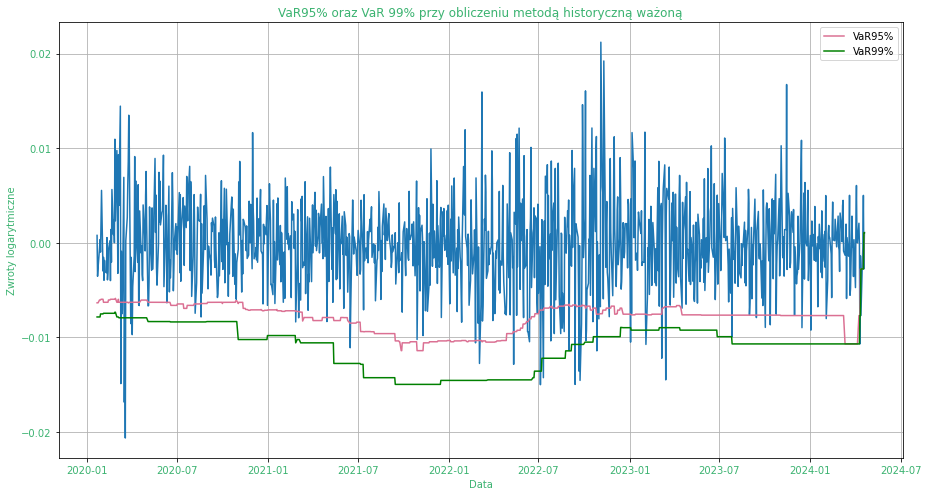

In [277]:

# Dynamicznie dostosowane okno
Var_values = []
for alpha in alphas:
    values = pd.Series(index=data['log_return'].index)
    for i in range(len(data['log_return'])):
        current_window = min(window, i + 1)  # Nie przekracza liczby dostępnych dni
        windowed_data = data['log_return'][:i+1].tail(current_window)
        
        dat = windowed_data
        weights = np.linspace(1, 0, num=len(dat))  # Przykładowe wagi malejące liniowo
        weights /= weights.sum()  # Normalizacja wag

        # Przygotowanie DataFrame
        df = pd.DataFrame({'dat': dat, 'weights': weights})

        # Sortowanie danych razem z wagami
        df_sorted = df.sort_values(by='dat')

        # Obliczenie skumulowanych wag
        df_sorted['cumulative_weight'] = df_sorted['weights'].cumsum()
        
        values[i] = df_sorted[df_sorted['cumulative_weight'] >= alpha].iloc[0]['dat']
    Var_values.append(values)

data['VaR95%'] = Var_values[0]  # Ujemny znak, jeśli VaR ma reprezentować potencjalną stratę
data['VaR99%'] = Var_values[1]  # Ujemny znak, jeśli VaR ma reprezentować potencjalną stratę

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR95%']
data['violation99'] = data['log_return'] < data['VaR99%']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")

plt.figure(figsize=[13,7])
plt.title('VaR95% oraz VaR 99% przy obliczeniu metodą historyczną ważoną', color = 'mediumseagreen')
plt.plot(data['Data'], data['log_return'])
plt.plot(data['Data'], data['VaR95%'], label = 'VaR95%', color = 'palevioletred')
plt.plot(data['Data'], data['VaR99%'], label = 'VaR99%', color = 'green')
plt.xlabel('Data', color = 'mediumseagreen')
plt.ylabel('Zwroty logarytmiczne', color = 'mediumseagreen')
plt.xticks(color = 'mediumseagreen')
plt.yticks(color = 'mediumseagreen')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('hist_wag.png')


exponential weighs

#### iii. using GARCH series filtering


In [278]:

# Przygotowanie danych (załóżmy, że 'returns' to twoje dane zwrotów)
returns = data['log_return']*100

# Lista do przechowywania wyników
results = []

# Test różnych kombinacji p i q
for p in range(1, 6):  # Testuj p od 1 do 3
    for q in range(1, 6):  # Testuj q od 1 do 3
        model = arch_model(returns, p=p, q=q, rescale=False)
        model_fit = model.fit(disp='off')
        results.append({
            'p': p,
            'q': q,
            'aic': model_fit.aic,
            'bic': model_fit.bic
        })

# Konwersja wyników na DataFrame
results_df = pd.DataFrame(results)

# Znalezienie modelu z najniższym AIC
best_model_aic = results_df.loc[results_df['aic'].idxmin()]
print("Najlepszy model ", best_model_aic)

Najlepszy model  p         1.000000
q         1.000000
aic    1410.905000
bic    1430.946248
Name: 0, dtype: float64


In [279]:

# Załóżmy, że 'data' to Twój DataFrame
window = 260
min_window = 20  # minimalna liczba danych do rozpoczęcia obliczeń
alphas = [0.05, 0.01]
Var_values = []

for alpha in alphas:
    values = pd.Series(index=data['log_return'].index)
    for i in range(len(data['log_return'])):
        # Ajustuj okno, aby zawsze korzystać z dostępnych danych
        current_window = max(min_window, min(window, i + 1))
        X = data['log_return'].iloc[max(0, i-current_window+1):i+1]*100
        if len(X.dropna()) >= min_window:
            try:
                am = arch_model(X.dropna(), mean='Zero', vol='Garch', p=1, o=0, q=1, dist='Normal', rescale=False)
                res = am.fit(update_freq=0, disp='off')
                forecast = res.forecast(horizon=1)
                s2 = forecast.variance.values[-1, -1]
                VaR_garch = -np.sqrt(s2) * stats.norm.ppf(1-alpha)
                values[i] = VaR_garch
            except Exception as e:
                print(f"Error at index {i}: {e}")
                values[i] = np.nan  # Handle errors or convergence issues
        else:
            values[i] = np.nan  # Not enough data to fit model
    Var_values.append(values/100)

data['VaR95%'] = Var_values[0].fillna(method='ffill')  # Fill NaN with forward fill if needed
data['VaR99%'] = Var_values[1].fillna(method='ffill')

mean_VaR95 = data['VaR95%'].mean()
mean_VaR99 = data['VaR99%'].mean()

print(f"Średni VaR95%: {mean_VaR95}")
print(f"Średni VaR99%: {mean_VaR99}")

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR95%']
data['violation99'] = data['log_return'] < data['VaR99%']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")

plt.figure(figsize=[13,7])
plt.title('VaR95% oraz VaR 99% przy obliczeniu metodą historyczną z filtrowaniem szeregiem GARCH', color = 'white')
plt.plot(data['Data'], data['log_return'])
plt.plot(data['Data'], data['VaR95%'], label = 'VaR95%', color = 'orchid')
plt.plot(data['Data'], data['VaR99%'], label = 'VaR99%', color = 'green')
plt.xlabel('Data', color = 'white')
plt.ylabel('Zwroty logarytmiczne', color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('hist_GARCH.png')


Error at index 19: 'Series' object is not callable
Error at index 20: 'Series' object is not callable
Error at index 21: 'Series' object is not callable
Error at index 22: 'Series' object is not callable
Error at index 23: 'Series' object is not callable
Error at index 24: 'Series' object is not callable
Error at index 25: 'Series' object is not callable
Error at index 26: 'Series' object is not callable
Error at index 27: 'Series' object is not callable
Error at index 28: 'Series' object is not callable
Error at index 29: 'Series' object is not callable
Error at index 30: 'Series' object is not callable
Error at index 31: 'Series' object is not callable
Error at index 32: 'Series' object is not callable
Error at index 33: 'Series' object is not callable
Error at index 34: 'Series' object is not callable
Error at index 35: 'Series' object is not callable


C:\Users\negul\AppData\Local\Temp\ipykernel_32584\3124971848.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(index=data['log_return'].index)


Error at index 36: 'Series' object is not callable
Error at index 37: 'Series' object is not callable
Error at index 38: 'Series' object is not callable
Error at index 39: 'Series' object is not callable
Error at index 40: 'Series' object is not callable
Error at index 41: 'Series' object is not callable
Error at index 42: 'Series' object is not callable
Error at index 43: 'Series' object is not callable
Error at index 44: 'Series' object is not callable
Error at index 45: 'Series' object is not callable
Error at index 46: 'Series' object is not callable
Error at index 47: 'Series' object is not callable
Error at index 48: 'Series' object is not callable
Error at index 49: 'Series' object is not callable
Error at index 50: 'Series' object is not callable
Error at index 51: 'Series' object is not callable
Error at index 52: 'Series' object is not callable
Error at index 53: 'Series' object is not callable
Error at index 54: 'Series' object is not callable
Error at index 55: 'Series' obj

C:\Users\negul\AppData\Local\Temp\ipykernel_32584\3124971848.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(index=data['log_return'].index)


Error at index 27: 'Series' object is not callable
Error at index 28: 'Series' object is not callable
Error at index 29: 'Series' object is not callable
Error at index 30: 'Series' object is not callable
Error at index 31: 'Series' object is not callable
Error at index 32: 'Series' object is not callable
Error at index 33: 'Series' object is not callable
Error at index 34: 'Series' object is not callable
Error at index 35: 'Series' object is not callable
Error at index 36: 'Series' object is not callable
Error at index 37: 'Series' object is not callable
Error at index 38: 'Series' object is not callable
Error at index 39: 'Series' object is not callable
Error at index 40: 'Series' object is not callable
Error at index 41: 'Series' object is not callable
Error at index 42: 'Series' object is not callable
Error at index 43: 'Series' object is not callable
Error at index 44: 'Series' object is not callable
Error at index 45: 'Series' object is not callable
Error at index 46: 'Series' obj

KeyboardInterrupt: 

In [ ]:
Var95 = np.zeros(len(data))
Var99 = np.zeros(len(data))
for j in range (0,len(data)):
    Var95[j] = mean_VaR95
    Var99[j] = mean_VaR99

data['VaR95%'] = Var95
data['VaR99%'] = Var99

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR95%']
data['violation99'] = data['log_return'] < data['VaR99%']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")

Liczba naruszeń VaR95%: 68
Liczba naruszeń VaR99%: 20


### c. Monte Carlo method with selected distribution/process

-0.007568238580480803 -0.011032258621858268
Liczba naruszeń VaR95%: 61
Liczba naruszeń VaR99%: 15


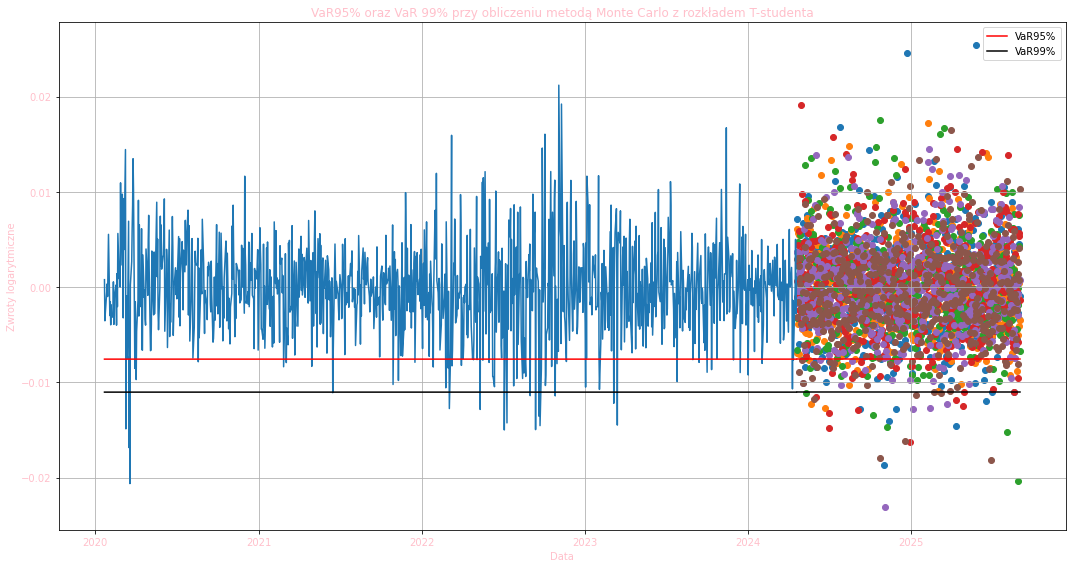

In [283]:
num_simulations = 500
mc_simulations = 3

plt.figure(figsize=[15,8])
plt.title('VaR95% oraz VaR 99% przy obliczeniu metodą Monte Carlo z rozkładem T-studenta', color = 'pink')
plt.plot(data['Data'], data['log_return'])

# Przykład dat, które są późniejsze od początku DataFrame
dates = pd.date_range(start="2024-04-20", periods=num_simulations, freq='D')
df = {
    'date': dates,
}
df = pd.DataFrame(df)
df.set_index('date', inplace=True)

colors = ['red', 'black']
labels = ['VaR95%', 'VaR99%']
Values_var = []
for alpha,color,label in zip(alphas, colors, labels):
    VaR = np.zeros(mc_simulations)
    for i in range (0,mc_simulations):
        dane = stats.t.rvs(params_t[0], size=num_simulations, loc=params_t[1], scale=params_t[2])
        df['MC'] = dane
        plt.scatter(dates,df['MC'])
        VaR[i] = df['MC'].quantile(alpha)
    Values_var.append(np.mean(VaR))
    
print(Values_var[0], Values_var[1])

Var95 = np.zeros(num_simulations)
Var99 = np.zeros(num_simulations)
for j in range (0,num_simulations):
    Var95[j] = np.mean(Values_var[0])
    Var99[j] = np.mean(Values_var[1])

df['VaR_95'] = Var95
df['VaR_99'] = Var99
  
Var95 = np.zeros(len(data))
Var99 = np.zeros(len(data))
for j in range (0,len(data)):
    Var95[j] = np.mean(Values_var[0])
    Var99[j] = np.mean(Values_var[1])

data['VaR_95'] = Var95
data['VaR_99'] = Var99

plt.plot(df['VaR_95'], label = 'VaR95%', color = 'red')
plt.plot(df['VaR_99'], label = 'VaR99%', color = 'black')
plt.plot(data['Data'], data['VaR_95'], color = 'red')
plt.plot(data['Data'],data['VaR_99'], color = 'black')

# Obliczenie naruszeń VaR
data['violation95'] = data['log_return'] < data['VaR_95']
data['violation99'] = data['log_return'] < data['VaR_99']
# Podsumowanie naruszeń
total_violations95 = data['violation95'].sum()
total_violations99 = data['violation99'].sum()

print(f"Liczba naruszeń VaR95%: {total_violations95}")
print(f"Liczba naruszeń VaR99%: {total_violations99}")


plt.xlabel('Data', color = 'pink')
plt.ylabel('Zwroty logarytmiczne', color = 'pink')
plt.xticks(color = 'pink')
plt.yticks(color = 'pink')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('MC.png')



In [ ]:
from scipy.stats import t
num_simulations = 10000
# Generowanie symulowanych zwrotów
simulated_returns = t.rvs(params_t[0], size=num_simulations, loc=params_t[1], scale=params_t[2])

# Obliczenie VaR95%
VaR_95 = np.percentile(simulated_returns, 5)

print("Obliczony VaR95% przy użyciu rozkładu t-Studenta wynosi:", VaR_95)


Obliczony VaR95% przy użyciu rozkładu t-Studenta wynosi: -0.0075681811285798605


In [ ]:


# Parametry
mean = params_t[1]
volatility = params_t[2] # Zmienność (odchylenie standardowe przyrostów)
steps = 260  # Liczba kroków (dni handlowych w roku)
simulations = 100000  # Liczba symulacji

# Generowanie trajektorii ruchu Browna
daily_returns = np.random.normal(mean, volatility, (steps, simulations))
price_paths = np.cumprod(1 + daily_returns, axis=0)  # Ścieżki cenowe

# Obliczenie końcowych cen i VaR95%
final_prices = price_paths[-1, :]
VaR_95_brown = np.percentile(final_prices, 5)
print("Obliczony VaR95% dla ruchu Browna wynosi:", VaR_95_brown)


Obliczony VaR95% dla ruchu Browna wynosi: 0.8865737684098978


In [ ]:


# Obliczenie VaR95% i VaR99%
VaR_95 = np.percentile(returns, 5)
VaR_99 = np.percentile(returns, 1)

# Przygotowanie danych do testowania wstecznego
actual_losses = -1 * returns  # Zakładamy, że straty to zwroty ujemne

# Liczenie naruszeń
violations_95 = sum(actual_losses < VaR_95)
violations_99 = sum(actual_losses < VaR_99)

# Wydruk wyników testowania
print(f"Violations for VaR95%: {violations_95}")
print(f"Violations for VaR99%: {violations_99}")


Violations for VaR95%: 58
Violations for VaR99%: 9
